## Sparse tomographic reconstructions

In [1]:
import linear_tomography.helper_xrayTomography as xrt
import linear_tomography.helper_generate_rays as pth
import numpy
import matplotlib.pyplot as plt
import scipy.sparse.linalg
import hmc_tomography

Define the problem

In [2]:
resample = False
plot_rays = False
    
# Create a 'true model' (we can use realtive slowness, because the forward problem is
# linear)
logo = [
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 0, -1, -1, -1, 0, 1, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, -1, 0, 0, 1, 0, 1, 0, 0],
    [0, 0, 1, 1, 0, 0, 0, -1, 0, 0, 1, 1, 1, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, -1, 0, 0, 1, 0, 1, 0, 0],
    [0, 0, 1, 1, 1, 0, 0, -1, 0, 0, 1, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
]
true_slowness = numpy.fliplr(numpy.array(logo).T) * 100
nx = true_slowness.shape[0]
ny = true_slowness.shape[1]

# Compute domain size
xmin = 0.0
xmax = 30.0
ymin = 0.0
ymax = 18.0
extent = (xmin, xmax, ymin, ymax)
xlength = xmax - xmin
ylength = ymax - ymin

# The aspect ratio of the cells has to be 1
assert xlength / ylength == nx / ny

Create the forward model matrix G and inspect the true model

Evaluating paths: 100%|██████████| 500/500 [00:00<00:00, 10703.74it/s]


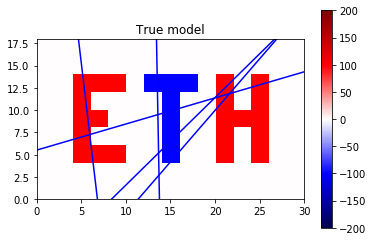

In [3]:
# Generate source-receiver setup randomly (but repeatedly)
paths = pth.generate_rays(extent, n_rays=500)

# Create forward model matrix and data
d, G = xrt.tracer(true_slowness, paths, extent=extent)

# Add some noise to the data
d += numpy.random.normal(loc=0, scale=50.0, size=d.shape)

plt.title("True model")
xrt.displayModel(
    true_slowness, paths=paths[:5], clim=(-200, 200), extent=extent, cmap=plt.cm.seismic
)
plt.show()

Inspecting a few rays and their entries in G

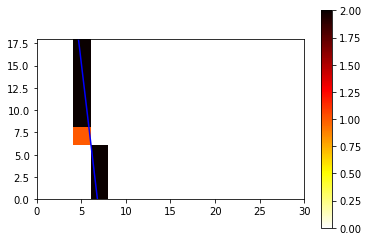

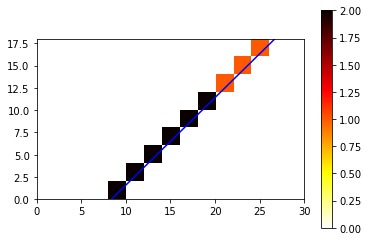

In [4]:
for i_path, path in enumerate(paths[0:2]):
    xrt.displayModel(
        G[i_path, :].reshape([nx, ny]),
        cmap=plt.cm.hot_r,
        paths=[path],
        extent=extent,
    )
    plt.show()

Solve the forward problem using sparse damped least squares

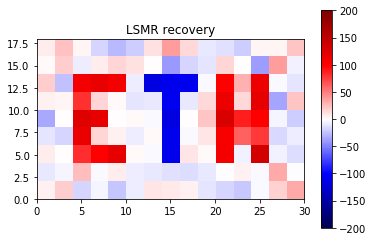

In [5]:
model_recovered = scipy.sparse.linalg.lsmr(G, d, damp=0.5)[0]
plt.title("LSMR recovery")
xrt.displayModel(
    model_recovered.reshape([nx, ny]),
    # paths=paths,
    clim=(-200, 200),
    extent=extent,
    cmap=plt.cm.seismic,
)

Solve the problem probabilistically, but naively

In [6]:
# Target from G, d, and data covariance
target = hmc_tomography.Targets.LinearMatrix(
    true_slowness.size, G, d[:, None], 50.0 ** 2
)

# Gaussian prior
prior_gauss = hmc_tomography.Priors.Normal(
    true_slowness.size,
    lower_bounds=-200 * numpy.ones((true_slowness.size, 1)),
    upper_bounds=200 * numpy.ones((true_slowness.size, 1)),
    means=numpy.zeros((true_slowness.size, 1)),
    covariance=20 * numpy.ones((true_slowness.size, 1)),
)

mass_matrix = hmc_tomography.MassMatrices.Unit(true_slowness.size)

# Sample the Normal-conditioned posterior
sampler = hmc_tomography.Samplers.HMC(target, mass_matrix, prior_gauss)

/home/larsgebraad/Documents/Hamiltonian Monte Carlo/hmc-tomography/hmc_tomography/Priors.py:293: Warning: Seems that you only passed a vector as the covariance matrix. It will be used as the covariance diagonal.
  Warning,


Sample

In [7]:
filename = "samples_linear_tomography.h5"
sampler.sample(
    filename,
    proposals=400000,
    online_thinning=10,
    time_step=0.02,
    initial_model=model_recovered[:, None],
);
sampler.sample_hdf5_file.close()

Tot. acc rate: 0.34. Last 100 acc rate: 0.34. Progress:  76%|███████▋  | 305862/400000 [16:41<05:08, 305.34it/s]


Visualize

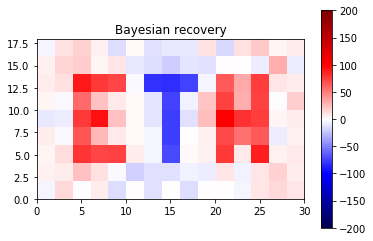

In [8]:
sampler.sample_hdf5_file.close()
with hmc_tomography.Post.Samples(filename, burn_in=500) as samples:
    mean = numpy.mean(samples[:-1, :], axis=1)
    std = numpy.std(samples[:-1, :], axis=1) # We will use this later
    plt.title("Bayesian recovery")
    xrt.displayModel(
        mean.reshape([nx, ny]),
        clim=(-200, 200),
        extent=extent,
        cmap=plt.cm.seismic,
    )

This is much worse than the linear recovery! How can that be when we threw (relatively) massive amounts of computation at the problem?

Of course, spending more resources on a problem won't magically make the result any better (at least in inverse problems) Why is this result worse? One obvious reason I could come up with is the 'regularisation'. In the deterministic case, the solution was 'damped' towards zero. THis was also done in this result. However, the damping turned out to be stronger in this case, probably because we chose our prior variance relatively small. One solution would be to increase prior variance.

However, a better solution would be to utilize the fact that the model consists of many zero entries. If we are able to come up with a prior that encodes this belief, our appraisal of reality might improve.

<div class="alert alert-info">

**Note:** The benefit of using sparsity is not uniquely applied in Bayesian inference. It is well understood and used in the machine learning community under the acronym LASSO. It is also regularly applied in deterministic inverse problems, where it works just as well. However, the deterministic implementation is not as straightforward as calling a few simple numpy routines. Therefore, it is ommitted in this notebook.
</div>

In [ ]:
# Laplace prior
prior_laplace = hmc_tomography.Priors.Sparse(
    true_slowness.size,
    lower_bounds=-200 * numpy.ones((true_slowness.size, 1)),
    upper_bounds=200 * numpy.ones((true_slowness.size, 1)),
    dispersion=1,
)

# Construct the Laplace-conditioned posterior
sampler_laplace = hmc_tomography.Samplers.HMC(target, mass_matrix, prior_laplace)

In [ ]:
filename_laplace = "samples_linear_tomography_laplace.h5"
sampler_laplace.sample(
    filename_laplace,
    proposals=100000,
    online_thinning=10,
    time_step=0.05,
    initial_model=100 * numpy.ones((true_slowness.size, 1)),
);

In [ ]:
with hmc_tomography.Post.Samples(filename_laplace, burn_in=500) as samples:
    mean_laplace = numpy.mean(samples[:-1, :], axis=1)
    std_laplace = numpy.std(samples[:-1, :], axis=1) # We will use this later
    plt.title("Bayesian recovery (Laplace prior)")
    xrt.displayModel(
        mean_laplace.reshape([nx, ny]),
        clim=(-200, 200),
        extent=extent,
        cmap=plt.cm.seismic,
    )

*Wow!*

In [ ]:
plt.figure(figsize=(10, 3))

max_std = numpy.max([std_laplace.max(), std.max()])

plt.subplot(121)
plt.title("Bayesian recovery\n(Gaussian prior)")
xrt.displayModel(
    std.reshape([nx, ny]),
    clim=(0, max_std),
    extent=extent,
    cmap=plt.cm.seismic,
)

plt.subplot(122)
plt.title("Bayesian recovery\n(Laplace prior)")
xrt.displayModel(
    std_laplace.reshape([nx, ny]), clim=(0, max_std), extent=extent, cmap=plt.cm.seismic
)

plt.tight_layout()
plt.show()

Interesting! Although the data is exactly the same, the assumptions on the model weigh heavily!

Let's investigate some priors of the Laplacian!

In [ ]:
dimensions = [
    ny * 1 + 4,
    ny * 1 + 3,
    ny * 2 + 4,
    ny * 2 + 3,
]
with hmc_tomography.Post.Samples(filename_laplace, burn_in=500) as samples:
    print(samples.raw_samples.shape)
    hmc_tomography.Post.Visualization.marginal_grid(samples, dimensions)

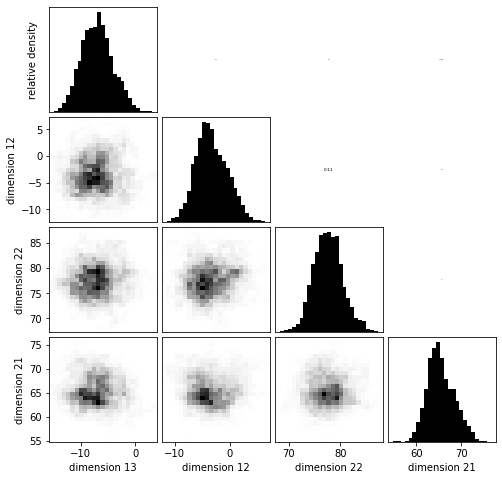

In [13]:
dimensions = [
    ny * 1 + 4,
    ny * 1 + 3,
    ny * 2 + 4,
    ny * 2 + 3,
]
with hmc_tomography.Post.Samples(filename, burn_in=5000) as samples:
    hmc_tomography.Post.Visualization.marginal_grid(samples, dimensions)